In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
np.set_printoptions(precision=2)

# Power growth model

Minule jsme si ukázali sílu strukturního modelu, konkrétně na lokálním lineárním modelu. Nyní si zkusíme model nelineární, na který budeme potřebovat nasadit rozšířený Kalmanův filtr (nebo nějaký jiný nelineární model). PGM model s driftem $k$ na $y_t$ má následující podobu (srovnejte s LLM):

$$
\begin{alignat}{2}
y_t &= k + \mu_t + \varepsilon_t, \qquad &\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \\
\mu_t &= \mu_{t-1}^{1+\nu_{t-1}} + \xi_t, \qquad &\xi_t \sim \mathcal{N}(0, \sigma_{\xi}^2), \\
\nu_t &= \rho\nu_{t-1} + \zeta_t, \qquad &\zeta_t \sim \mathcal{N}(0, \sigma_{\zeta}^2),
\end{alignat}
$$

kde $\rho\in[0,1]$ je "discounting" faktor.

Modely tohoto typu jsou populární např. v epidemiologii, kde se uvažuje namísto mocniny přímo exponenciální funkce (a odtud je další cesta k "magickému" reprodukčnímu číslu). Související proces bude logicky velmi citlivý na kombinace hodnot $\nu_t$ a $\mu_t$. Stačí, aby se chviličku udržela nevhodná kombinace a proces exploduje.

Podívejme se na pár realizací. Pro simulaci si nastavíme rozumnou hodnotu $k$, aby nám později filtrace neskončila odmocňováním záporných čísel.

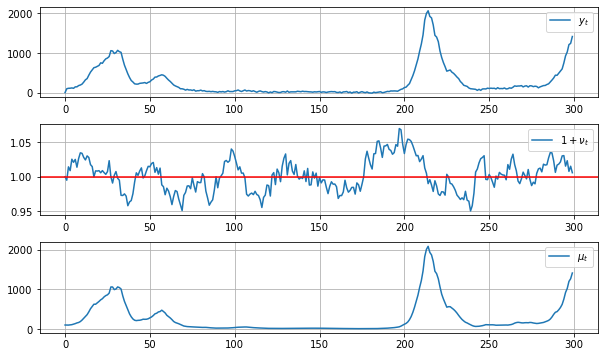

In [165]:
ndat = 300
npred = 50

sigma_epsilon = 10
sigma_xi = .1
sigma_zeta = .01
rho = 0.9
k = 2
mu = np.zeros(ndat); mu[0] = 100.
nu = np.zeros(ndat)
y = np.zeros(ndat)

for t in range(1, ndat):
    nu[t] = rho * nu[t-1] + norm.rvs(scale=sigma_zeta)
    mu[t] = mu[t-1]**(1+nu[t-1]) + norm.rvs(scale=sigma_xi)
    y[t] = k + mu[t] + norm.rvs(scale=sigma_epsilon)
    if mu[t] < 0:
        break
    
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(y, label=r'$y_t$')
plt.legend()
plt.subplot(3,1,2)
plt.plot(1+nu, label=r'$1+\nu_t$')
plt.axhline(1, color='red')
plt.legend()
plt.subplot(3,1,3)
plt.plot(mu, label=r'$\mu_t$')
plt.legend()
plt.show()

Vzpomeňme na EKF z přednášky:

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Linearizace pro predikci
$$
\begin{align}
F_t &= f_t'(\hat{x}_{t-1}^+).
\end{align}
$$

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{-} &= f_t(\hat{x}_{t-1}^+, u_t),\\
P_t^{-} &= F_t P_{t-1}^{+} F_t^\intercal + Q_t.
\end{align}
$$

    - Linearizace pro korekci
$$
\begin{align}
H_t &= h_t'(\hat{x}_{t}^-).
\end{align}
$$

    - Korekce (datový update) stavů pozorováním
$$
\begin{aligned}
K_t &= P_{t}^- H_t^\intercal (H_t P_{t}^{-} H_t^\intercal + R_t)^{-1},\\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t\left[y_t - h_t\left(\hat{x}_{t}^{-}\right)\right], \\
P_t^{+} &= (I - K_t H_t) P_{t}^{-} (I - K_t H_t)^\intercal + K_t R_t K_t^\intercal.
\end{aligned}
$$

### Připomeňme náš model:

$$
\begin{alignat}{2}
y_t &= k + \mu_t + \varepsilon_t, \qquad &\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \\
\mu_t &= \mu_{t-1}^{1+\nu_{t-1}} + \xi_t, \qquad &\xi_t \sim \mathcal{N}(0, \sigma_{\xi}^2), \\
\nu_t &= \rho\nu_{t-1} + \zeta_t, \qquad &\zeta_t \sim \mathcal{N}(0, \sigma_{\zeta}^2),
\end{alignat}
$$

kde $x_t = [\mu_t, \nu_t]^\intercal$. Rovnice pro pozorování $y_t$ je lineární, linearizovat nemusíme:

$$
\begin{aligned}
y_t &= H_t x_t + B_t u_t + \varepsilon_t \\
&= [1, 0]
\begin{bmatrix} \mu_t \\ \nu_t \end{bmatrix} + 2 \cdot 1 + \varepsilon_t.
\end{aligned}
$$

Rovnice pro vývoj stavů už ale lineární není:

$$
\begin{aligned}
\begin{bmatrix} \mu_t \\ \nu_t \end{bmatrix}
= 
\begin{bmatrix} \mu_{t-1}^{1+\nu_{t-1}} \\ \rho\nu_{t-1} \end{bmatrix}
+ \begin{bmatrix} \xi_t \\ \zeta_t \end{bmatrix}
\end{aligned}
$$

Budeme tedy linearizovat. Musíme určit derivace dvourozměrné funkce $f_t()$ - prvního vektoru na pravé straně:

$$
F_t =
\begin{bmatrix}
(\nu_{t-1} + 1) \mu_{t-1}^{\nu_{t-1}} &
\mu_{t-1}^{1+\nu_{t-1}} \ln \mu_{t-1} \\
0 & \rho
\end{bmatrix}.
$$

V EKF oproti klasickému lineárnímu KF:
1. V predikci stavu použijeme **nelineární rovnici** na predikci $\hat{x}_t^-$ a **matici** $F_t$ na predikci $P_t^-$. Pozor, matice $F_t$ je proměnná v čase a pokaždé musíme sestavit novou!
2. Při updatu (korekci) použijeme **lineární rovnici měření** stejně jako v lineárních modelech, neboť jsme nic nelinerizovali.

Pojďme si tedy upravit třídu `KF` na `EKF`. Změny jsou vyznačeny:

In [166]:
class EKF():
    def __init__(self, F, B, H, R, Q):
        self.F = F                          ### Dtto jako A u linearniho KF
        self.B = B
        self.H = H
        self.R = R
        self.Q = Q
        self.P = np.eye(self.Q.shape[0]) * .1
        self.x = np.array([10, .5])
        self.log_x = []
        self.rho = 1                         ### ZDE jsme přidali rho
    
    def predict(self, u=None):               ### ZDE jsme změnili výpočet predikovaných veličin
        mu_t = self.x[0]                     ### budu psát _t místo _{t-1}
        nu_t = self.x[1]
        F = np.array([[(nu_t + 1) * mu_t**nu_t, mu_t**(1 + nu_t) * np.log(mu_t)],
                      [0, self.rho]])
        xminus = np.array([mu_t ** (1. + nu_t), rho * nu_t])
        Pminus = F.dot(self.P).dot(F.T) + self.Q
        self.x = xminus
        self.P = Pminus
    
    def correct(self, yt):
        HPHT = self.H.dot(self.P).dot(self.H.T)
        zavorka_inv = np.linalg.inv(HPHT + self.R)
        K = self.P.dot(self.H.T).dot(zavorka_inv)
        innovation = yt - self.H.dot(self.x)
        xplus = self.x + K.dot(innovation)
        zavorka = np.eye(K.shape[0]) - K.dot(self.H)
        KRKT = K.dot(self.R).dot(K.T)
        Pplus = zavorka.dot(self.P).dot(zavorka.T) + KRKT
        self.x = xplus
        self.P = Pplus
    
    def log(self):
        self.log_x.append(self.x)

In [167]:
Q = np.diag([sigma_xi**2, sigma_zeta**2])
H = np.array([[1, 0]])
R = np.atleast_2d(sigma_epsilon**2)

kf = EKF(F=None, B=2., H=H, R=R, Q=Q)
kf.rho = rho
for t in range(ndat):
    kf.predict(u=1)
    kf.correct(np.atleast_1d(y[t]))
    kf.log()
    
for t in range(npred):
    kf.predict(u=1)
    kf.log()

log_x = np.array(kf.log_x).T

### Predikce

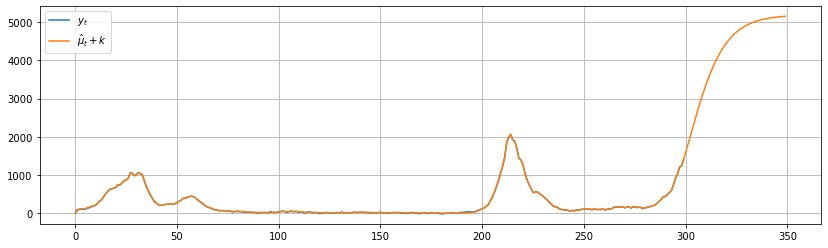

In [168]:
plt.figure(figsize=(14,4))
plt.plot(y, label=r'$y_t$')
plt.plot(k + log_x[0].T, label=r'$\hat{\mu}_t + k$')
plt.legend()

### Odhady stavových veličin

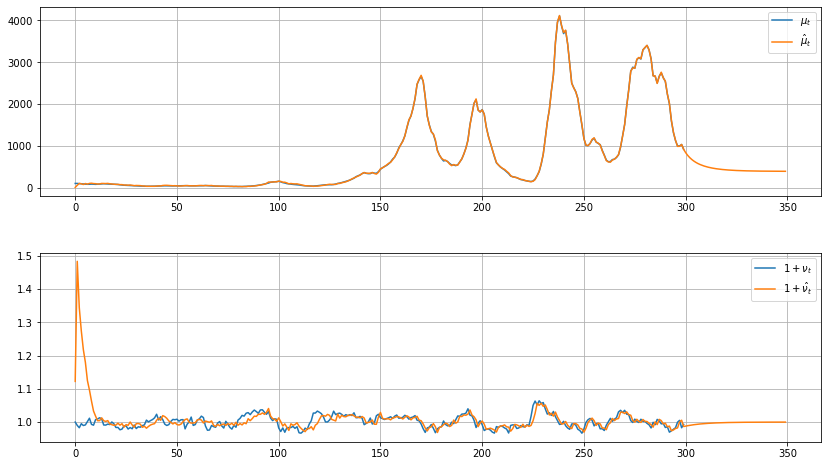

In [164]:
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(mu, label=r'${\mu}_t$')
plt.plot(log_x[0].T, label=r'$\hat{\mu}_t$')
plt.legend()
plt.subplot(2,1,2)
plt.plot(1+nu, label=r'$1+\nu_t$')
plt.plot(1+log_x[1].T, label=r'$1+\hat{\nu}_t$')
plt.legend()